# Lorenz96
For a number of variables $ J \in \mathbb{N} $, external force $ F \in \mathbb{R} $ and state variable $ \mathbb{u} \in \mathbb{R}^J $ on 1D periodic domain, the Lorenz 96 equation (Lorenz 1996) is given by

$$ \frac {du^{i}}{dt} =(u^{i+1}-u^{i-2})u^{i-1}-u^{i}+F, $$

with $ u^{-1} = u^{J-1} $, $ u^0 = u^J $, and $ u^{J+1} = u^1 $.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from da.l96 import lorenz96
from da.scheme import rk4
from da.visualize import plot_loss
from da.etkf import ETKF

In [2]:
# Lorenz96
# J: dim of state space
J = 40

# F: forcing
F = 8


## Generate the true trajectory

In [3]:
# generate data
# dt: time step size
dt = 0.01

# N: number of time steps, 2 years : 20*360*2 steps
N = 20*360*2 

# initial state near the statinary point
x0 = F*np.ones(J) # the statinary point
x0[19] *= 1.001 # perturb

# use my modules
scheme = rk4
p = (F, )

try:
    x_true = np.load("data/x_true_l96.npy")
    print("x_true loaded:", x_true.shape)
except:
    result = np.zeros((N,len(x0)))
    x = x0
    result[0] = x[:]

    for n in range(1,N):
        t = n*dt
        x = scheme(lorenz96, t, x, p, dt)
        result[n] = x[:]


    x_true = result[360*20:][::5] # spin up 1 year and save per 6 hours
    print(x_true.shape)
    np.save(f"data/x_true_l96", x_true)

x_true loaded: (1440, 40)


## DA setting

In [4]:
# assimilation interval
Dt = 0.05

# Model function for EnKF
def M(x, Dt):
    for i in range(int(Dt/0.01)):
        x = rk4(lorenz96, 0, x, p, 0.01)
    return x

# 観測
H_diag = np.ones(J)
H = np.diag(H_diag)
print("diag of H", H_diag)
print("rank(H)", np.linalg.matrix_rank(H))

# Observation error covariance
r = 0.1**0.5
R = r**2*np.eye(J)

# load true states
Nt = N//5//6
x_true = np.load('data/x_true_l96.npy')[:Nt]

# initial state for EnKF
# x_0 = x_true[np.random.randint(len(x_true)-1)]

# P_0 = 25*np.eye(J)

# ensemble size
# m = 41

# deterministic ensemble
m = J+1
X_0 = np.zeros((m, J))
for i in range(m):
    if i == J:
       e = X_0[:J].sum(axis=0)
       X_0[J] = e
    else:
        e = np.zeros(J)
        e[i] = 1
        X_0[i] = e
X_0 *= 1

# inflation
# alpha = 1.5

diag of H [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rank(H) 40


0.024999999999999988


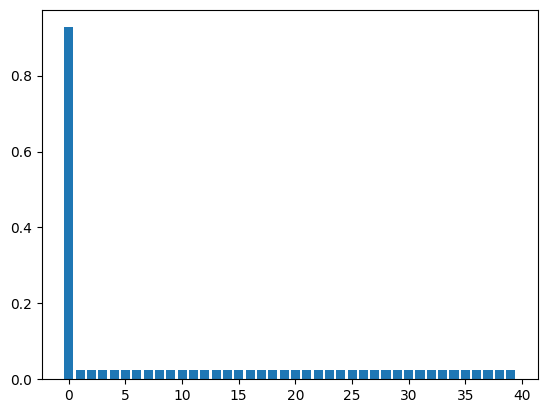

In [5]:
# eigen values of initial cov
dX_0 = X_0 - X_0.mean(axis=0, keepdims=True)
P_0 = dX_0.T @ (dX_0) / (m-1)

plt.bar(np.arange(J), sorted(np.linalg.eigvals(P_0), reverse=True))
print(min(np.linalg.eigvals(P_0)))

## Run DA over $\alpha$

In [6]:
import scipy as sp
alpha_list = [1.0, 1.1, 5.0]
seed_list = np.arange(20)

paramname = "m(41)-alpha(1.0=1.1=5.0)-seeds(20)"
try:
    # raise
    xa_alpha = np.load(f"data/xa_alpha-{paramname}.npy")
    evals_alpha = np.load(f"data/evals_alpha-{paramname}.npy")
except:
    evals_alpha = np.zeros((len(alpha_list), len(seed_list), Nt, J))
    xa_alpha = np.zeros((len(alpha_list), len(seed_list), Nt, J))
    Y = np.zeros((len(seed_list), Nt, H.shape[0]))
    for i, alpha in enumerate(alpha_list):
        print("alpha:", alpha)
        for j, seed in enumerate(seed_list):
            # random seed
            np.random.seed(seed)

            # generate observation
            y = (H@x_true.T).T
            y += np.random.multivariate_normal(mean=np.zeros_like(y[0]), cov=R, size=len(y))
            if i == 0:
                Y[j] = y
            
            # run da
            etkf = ETKF(M, H, R, alpha=alpha**2, store_ensemble=True)
            etkf.initialize(X_0)
            for y_obs in y:
                etkf.forecast(Dt)
                etkf.update(y_obs)

            xa_alpha[i, j] = etkf.x

            Pf = []
            for X in etkf.X_f:
                m = X.shape[0]
                dX = X - X.mean(axis=0, keepdims=True)
                P = dX.T @ (dX) / (m-1)
                Pf.append(P)
            evals = np.array([sorted(sp.linalg.eigvals(Pf_t).real, reverse=True) for Pf_t in Pf])
            evals_alpha[i, j] = evals

    np.save(f"data/xa_alpha-{paramname}", xa_alpha)
    np.save(f"data/evals_alpha-{paramname}", evals_alpha)

## Theoretical error bound
For each time, let $ \bar{v}, u \in \mathbb{R}^J $ be the analysis mean and true state respectively.
### SE(Square Error)
$$ \text{SE} = \sum_{i=1}^J |\bar{v}^i - u^i|^2 $$
Theoretical bound of SE: `Jr^2` $ \sim $ observarion SE ($ m\gamma^2 $ in the paper).

##### ※RMSE(Root Mean Square Error)
$ \text{RMSE} = \left(\frac{1}{J} \sum_{i=1}^J |\bar{v}^i - u^i|^2\right)^{1/2} $, theoretical bound of RMSE: `r` $ \approx $ observarion RMSE ($ \gamma $ in the paper).

## Plot errors and minimum eigenvalues

In [7]:
def loss_sq(X, Y):
    """
    X, Y: (Nt, J)
    """
    return np.sum((X-Y)**2, axis=-1)


def stats(X):
    """
    X: (N_seed, Nt)
    """
    return X.mean(axis=0), X.std(axis=0)

load file
m(41)-alpha(1.0=1.1=5.0)-seeds(20)


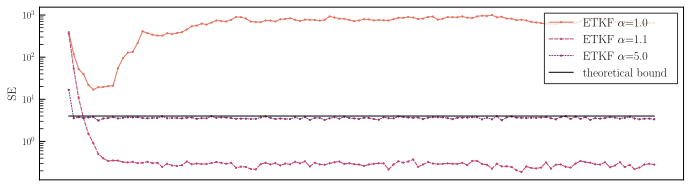

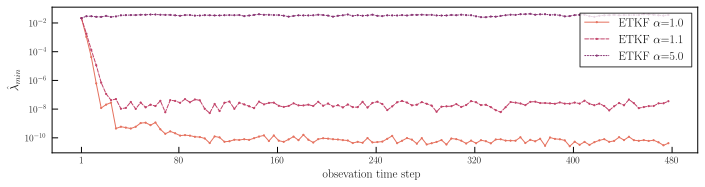

In [8]:
from visualize import get_color_palette, get_linestyle_cycle, get_marker_cycle

# load data
print("load file")
print(paramname)
xa_alpha = np.load(f"data/xa_alpha-{paramname}.npy")
evals_alpha = np.load(f"data/evals_alpha-{paramname}.npy")

# Plot
per_vis = 4 # NOTE: plot SE mean over 20 realizations per 4 time steps (1time step:6h)
per_ticklabel = per_vis * 20

lw = 1
# --------------

fig1, ax1 = plt.subplots(figsize=(10,3))
fig2, ax2 = plt.subplots(figsize=(10.2,3))

num_alpha = len(alpha_list)
colors = get_color_palette(num_alpha, "flare")
line_cycle = get_linestyle_cycle()
# marker_cycle = get_marker_cycle()

time_ticks = np.arange(Nt//per_vis)*per_vis + 1
time_ticklabels = np.arange(Nt//per_ticklabel+1)*per_ticklabel
time_ticklabels[0] = 1
for i, xa in enumerate(xa_alpha):
    alpha = alpha_list[i]
    evals = evals_alpha[i]

    # set plot vars
    color = colors[i]
    ls = next(line_cycle)
    # marker = next(marker_cycle)

    # compute SE stats
    se = loss_sq(x_true[None, :, :] - xa, 0)
    se_m, _ = stats(se) # NOTE: std does not make sense

    # compute eigenvalues stats
    evals_m, evals_std = stats(evals)

    # plot square error of analysis
    ax1.plot(time_ticks, se_m[::per_vis], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=".")
    # for se_k in se:
    #     ax1.plot(time_ticks, se_k[::per_vis], lw=lw/2, color=color, alpha=0.2)
    # ax1.fill_between(time_ticks, se_m[::per_vis]+se_std[::per_vis], se_m[::per_vis]-se_std[::per_vis], color=color, alpha=0.5) # NOTE: std does not make sense

    # plot minimum eigenvalues of prediction ensemble covariance
    ax2.plot(time_ticks, evals_m[:, -1][::per_vis], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=".")
    # for evals_k in evals:
    #     ax2.plot(time_ticks, evals_k[:, -1][::per_vis], lw=lw/2, color=color, alpha=0.2)

# plot square error of observation
# for y_i in Y:
#     plot_loss((H@x_true.T).T[::per_vis], y_i[::per_vis], loss_sq, x_index=time_ticks, ax=ax1, lw=lw/2, color="black", alpha=0.2)
# plot_loss((H@x_true.T).T[::per_vis], y[::per_vis], loss_sq, x_index=time_ticks, ax=ax1, label='observation', lw=lw/2, color="black", alpha=0.2)

# excepted(theoretical) error bound
ax1.plot(time_ticks, J*r**2*np.ones_like(time_ticks), label='theoretical bound', lw=lw, c="black")

ax1.set_ylabel("SE")
ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1, 1), loc='upper right')
ax1.set_xticks([])
fig1.tight_layout()

ax2.set_xlabel("obsevation time step")
ax2.set_ylabel("$\\hat{\\lambda}_{min}$")
ax2.set_yscale("log")
ax2.set_xticks(time_ticklabels)
ax2.set_xticklabels(time_ticklabels)
ax2.legend(bbox_to_anchor=(1, 1), loc='upper right')
fig2.tight_layout()

# save fig
fig1.savefig("data/l96-etkf-inflation_se.pdf", transparent=True)
fig2.savefig("data/l96-etkf-inflation_eval.pdf", transparent=True)

## Appendix
visualize other eigenvalues of the prediction ensemble covariance.

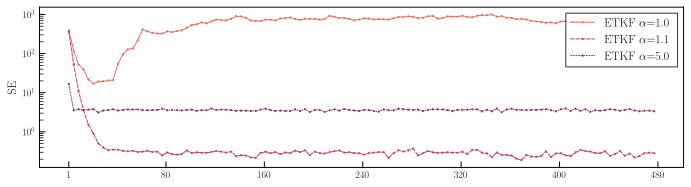

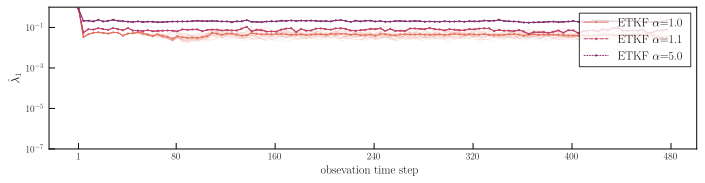

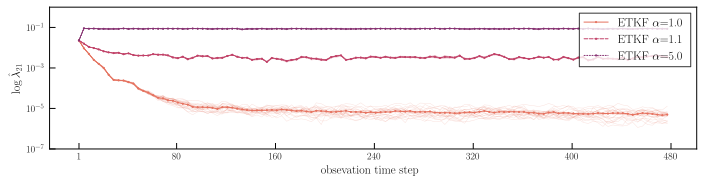

In [10]:
from visualize import get_color_palette, get_linestyle_cycle, get_marker_cycle
# Plot
per_vis = 4 # NOTE: plot RMSE per 4 time steps (1time step:6h)
per_ticklabel = per_vis * 20

lw = 1
# --------------
idx1 = 0
idx2 = 20

fig1, ax1 = plt.subplots(figsize=(10,3))
fig2, ax2 = plt.subplots(figsize=(10.2,3))
fig3, ax3 = plt.subplots(figsize=(10.2,3))

num_alpha = len(alpha_list)
colors = get_color_palette(num_alpha, "flare")
line_cycle = get_linestyle_cycle()
marker_cycle = get_marker_cycle()

time_ticks = np.arange(Nt//per_vis)*per_vis + 1
time_ticklabels = np.arange(Nt//per_ticklabel+1)*per_ticklabel
time_ticklabels[0] = 1
for i, xa in enumerate(xa_alpha):
    alpha = alpha_list[i]
    evals = evals_alpha[i]
    
    # set plot vars
    color = colors[i]
    ls = next(line_cycle)
    marker = next(marker_cycle)

    # compute SE stats
    se = loss_sq(x_true[None, :, :] - xa, 0)
    se_m, _ = stats(se) # NOTE: std does not make sense
    
    # compute eigenvalues stats
    evals_m, evals_std = stats(evals)

    # plot square error of analysis
    ax1.plot(time_ticks, se_m[::per_vis], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=".")
    # for se_k in se:
    #     ax1.plot(time_ticks, se_k[::per_vis], lw=lw/2, color=color, alpha=0.2)
    # plot_loss(x_true[::per_vis], xa[::per_vis], loss_sq, x_index=time_ticks, ax=ax1, label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=marker)

    # plot {idx1}-th eigenvalues of prediction ensemble covariance
    for evals_k in evals:
        ax2.plot(time_ticks, evals_k[:, idx1][::per_vis], lw=lw/2, color=color, alpha=0.2)
    ax2.plot(time_ticks, evals_m[:, idx1][::per_vis], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=".")

    # plot {idx2}-th eigenvalues of prediction ensemble covariance
    for evals_k in evals:
        ax3.plot(time_ticks, evals_k[:, idx2][::per_vis], lw=lw/2, color=color, alpha=0.2)
    ax3.plot(time_ticks, evals_m[:, idx2][::per_vis], label=f"ETKF $\\alpha$={alpha}", lw=lw, color=color, ls=ls, marker=".")

# plot square error of observation
# plot_loss((H@x_true.T).T[::per_vis], y[::per_vis], loss_sq, x_index=time_ticks, ax=ax1, label='observation', lw=lw, c="k")

ax1.set_ylabel("SE")
ax1.set_yscale("log")
ax1.legend(bbox_to_anchor=(1, 1), loc='upper right')
ax1.set_xticks(time_ticklabels)
ax1.set_xticklabels(time_ticklabels)
fig1.tight_layout()

ax2.set_xlabel("obsevation time step")
ax2.set_ylabel("$\\hat{\\lambda}_{"+f"{idx1+1}"+"}$")
ax2.set_yscale("log")
ax2.set_ylim([1e-7, 1])
ax2.set_xticks(time_ticklabels)
ax2.set_xticklabels(time_ticklabels)
ax2.legend(bbox_to_anchor=(1, 1), loc='upper right')
fig2.tight_layout()

ax3.set_xlabel("obsevation time step")
ax3.set_ylabel("$\\log\\hat{\\lambda}_{"+f"{idx2+1}"+"}$")
ax3.set_yscale("log")
ax3.set_ylim([1e-7, 1])
ax3.set_xticks(time_ticklabels)
ax3.set_xticklabels(time_ticklabels)
ax3.legend(bbox_to_anchor=(1, 1), loc='upper right')
fig3.tight_layout()


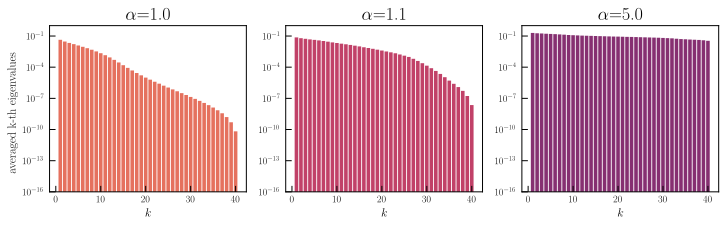

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
t_spinup = 200
for i, evals in enumerate(evals_alpha):
    alpha = alpha_list[i]
    
    # set plot vars
    color = colors[i]
    ls = next(line_cycle)
    marker = next(marker_cycle)

    ax[i].bar(np.arange(J)+1, evals[:, t_spinup:].mean(axis=0).mean(axis=0), color=color)
    ax[i].set_yscale("log")
    ax[i].set_ylim([1e-16, 1])
    ax[i].set_title(f"$\\alpha$={alpha}")
    ax[i].set_xlabel("$k$")
    if i == 0:
        ax[i].set_ylabel("averaged k-th eigenvalues")